In [486]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from models.MLP import MLP
from models.LinearModels import OLS, RidgeRegression
from models.KalmanFilterMLP import KalmanFilterMLP
from utils.results import compute_rsquared
import statsmodels.api as sm
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

## Loading and Preprocessing Data

### Loading Google Trends

In [487]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [488]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [489]:
data, all_gdps, all_gts = load_data()

In [490]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(
                                                                  train_pct=TRAIN_PROPORTION, 
                                                                  mode=MODE, 
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180,
                                                                  noisy_data_stds=[0.001, 0.003, 0.006],
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs])

Splitting date : 2022-06-01 00:00:00
X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)


## Training the neural network

In [491]:
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid

country_train.shape, country_valid.shape, preprocessor.dates_train.shape, preprocessor.dates_valid.shape

((1780,), (53,), (1780,), (53,))

In [492]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [493]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_features, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    
# Function to set random seed
def set_seed(seed):
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (if available)
    torch.cuda.manual_seed_all(seed)  # PyTorch for all GPUs (if multiple GPUs are used)
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Avoids non-deterministic optimizations
    
def train_nn(x_train, y_train, x_valid, y_valid, num_epochs=2000, learning_rate=1e-3, weight_decay=1e-3, verbose = True):
    num_features = x_train.shape[1]
    model = NeuralNetwork(num_features=num_features).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    
    x_train_t = torch.tensor(x_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    x_valid_t = torch.tensor(x_valid, dtype=torch.float32).to(device)
    y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device).unsqueeze(1)

    training_loss = []
    validation_loss = []
    valid_r_squared = []
    
    epoch_range = tqdm(range(num_epochs)) if verbose else range(num_epochs)
    for t in epoch_range:
        model.train()
        y_pred = model(x_train_t)
        loss_train = loss_fn(y_pred, y_train_t)

        model.eval()
        loss_valid = loss_fn(model(x_valid_t), y_valid_t)
        model.train()

        r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())

        valid_r_squared.append(r_squared)
        training_loss.append(loss_train.item())
        validation_loss.append(loss_valid.item())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
    model.eval()
    y_pred = model(x_valid_t)

    v_loss = loss_fn(y_pred, y_valid_t)
    validation_loss.append(v_loss.item())
    print(f"Validation loss: {v_loss.item()}")

    t_loss = loss_fn(model(x_train_t), y_train_t)
    training_loss.append(t_loss.item())
    print(f"Training loss: {t_loss.item()}")

    r_squared = compute_rsquared(y_valid, model(torch.tensor(x_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten())
    valid_r_squared.append(r_squared)
    print(f"Validation R^2: {r_squared}")
    
    return model, training_loss, validation_loss, valid_r_squared

In [494]:
model, training_loss, validation_loss, validation_r_squared = train_nn(X_train, y_train, X_valid, y_valid, num_epochs=1000, learning_rate=1e-4, weight_decay=7e-2)

best_valid_r_squared = max(validation_r_squared)
print(f"Best validation R^2: {best_valid_r_squared} at epoch {validation_r_squared.index(best_valid_r_squared)}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Validation loss: 0.8299282789230347
Training loss: 0.0755564421415329
Validation R^2: -0.07147222887427129
Best validation R^2: 0.3960432063954893 at epoch 449


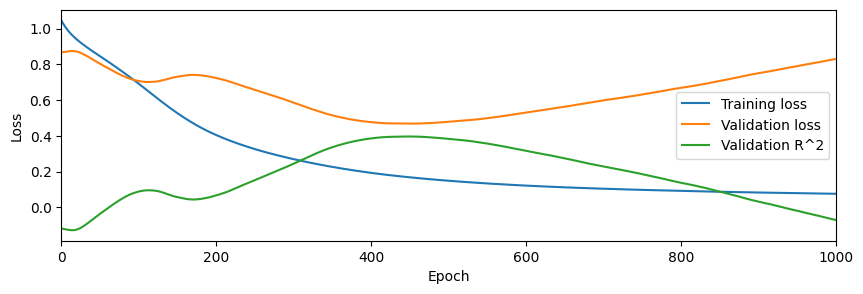

In [495]:
plt.figure(figsize=(10, 3))
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.plot(validation_r_squared, label="Validation R^2")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [496]:
# Make bootrapping
n_bootstrap = 250
n = len(X_train)
n_features = X_train.shape[1]

n_countries = len(np.unique(preprocessor.country_train))

bootstrap_size = np.ceil(n / n_countries).astype(int)

bootstrap_models = []
mse_bootstrap = np.zeros(n_bootstrap)
rsquared_bootstrap = np.zeros(n_bootstrap)

for i in tqdm(range(n_bootstrap)):
    # Make a bootstrap sample of size bootstrap_size
    set_seed(SEED + i)

    indices_per_country = [np.where(preprocessor.country_train == c)[0] for c in np.unique(preprocessor.country_train)]
    bootstrap_idx = np.concatenate([np.random.choice(indices, size=bootstrap_size, replace=True) for indices in indices_per_country])
    x_train_bootstrap = X_train[bootstrap_idx]
    y_train_bootstrap = y_train[bootstrap_idx]

    model_bootstrap, _, _, _ = train_nn(x_train_bootstrap, y_train_bootstrap, X_valid, y_valid, num_epochs=400, learning_rate=1e-4, weight_decay=7e-2, verbose=False)
    y_pred = model_bootstrap(torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

    mse = mean_squared_error(y_valid, y_pred)
    rsquared = compute_rsquared(y_valid, y_pred)

    bootstrap_models.append(model_bootstrap)
    mse_bootstrap[i] = mse
    rsquared_bootstrap[i] = rsquared

# Aggregate the predictions
y_pred = np.zeros((X_valid.shape[0], n_bootstrap))
for i in range(n_bootstrap):
    y_pred[:, i] = bootstrap_models[i](torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

y_pred_mean = np.mean(y_pred, axis=1)
y_pred_std = np.std(y_pred, axis=1)
y_pred_median = np.median(y_pred, axis=1)

# Get the model with the best R squared
best_model_idx = np.argmax(rsquared_bootstrap)
best_model = bootstrap_models[best_model_idx]
best_rsquared = rsquared_bootstrap[best_model_idx]
y_pred_best = best_model(torch.tensor(X_valid, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()

  0%|          | 0/250 [00:00<?, ?it/s]

Validation loss: 0.7557001113891602
Training loss: 0.15049569308757782
Validation R^2: 0.024359353640063475
Validation loss: 0.6273724436759949
Training loss: 0.16717293858528137
Validation R^2: 0.19003586904901404
Validation loss: 0.7370264530181885
Training loss: 0.14339739084243774
Validation R^2: 0.04846793014515027
Validation loss: 0.6271573305130005
Training loss: 0.16832388937473297
Validation R^2: 0.1903135484361569
Validation loss: 0.561611533164978
Training loss: 0.14842849969863892
Validation R^2: 0.2749359078427118
Validation loss: 0.6882500648498535
Training loss: 0.17051248252391815
Validation R^2: 0.11144025509616007
Validation loss: 0.5863342881202698
Training loss: 0.1741955578327179
Validation R^2: 0.24301780709968535
Validation loss: 0.5531668663024902
Training loss: 0.17136844992637634
Validation R^2: 0.2858383127520542
Validation loss: 0.6264151930809021
Training loss: 0.1669105440378189
Validation R^2: 0.1912717298847455
Validation loss: 0.5887801051139832
Trainin

In [497]:
def predict_from_bootstraps(x):
    x_t = torch.tensor(x, dtype=torch.float32).to(device)
    y_pred = np.zeros((n_bootstrap, x.shape[0]))
    for i in range(n_bootstrap):
        y_pred[i] = bootstrap_models[i](x_t).cpu().detach().numpy().flatten()
    
    y_pred_mean = np.mean(y_pred, axis=0)
    y_pred_std = np.std(y_pred, axis=0)
    y_pred_median = np.median(y_pred, axis=0)

    return y_pred_mean, y_pred_std, y_pred_median

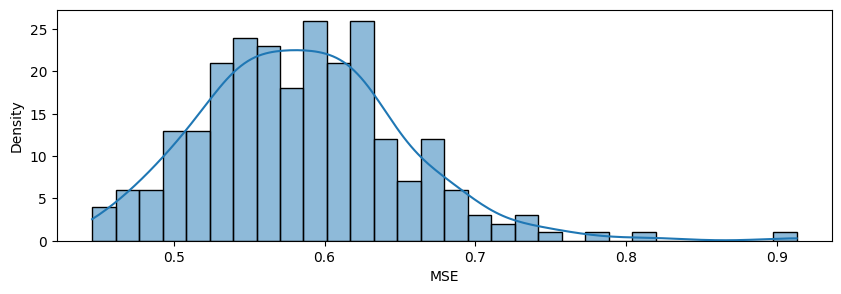

In [498]:
# Plot the MSE
plt.figure(figsize=(10, 3))
sns.histplot(mse_bootstrap, bins=30, kde=True)
plt.xlabel("MSE")
plt.ylabel("Density")
plt.show()

Bootstrapped R^2: 0.30711577865212025
Bootstrapped MSE: 0.536686036341201


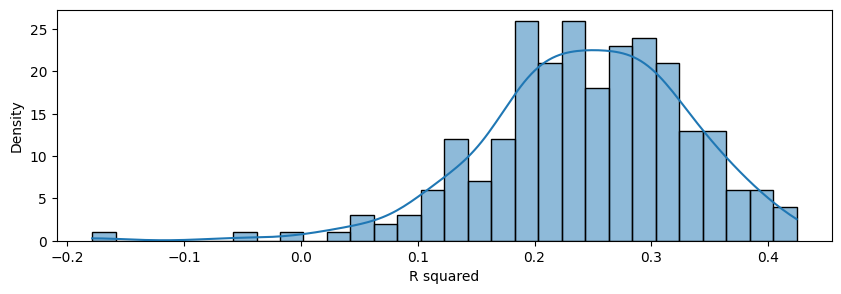

In [499]:
# Plot the r squared
bootstrapped_r2 = compute_rsquared(y_valid, y_pred_mean)
bootstrapped_mse = mean_squared_error(y_valid, y_pred_mean)
print(f"Bootstrapped R^2: {bootstrapped_r2}")
print(f"Bootstrapped MSE: {bootstrapped_mse}")

plt.figure(figsize=(10, 3))
sns.histplot(rsquared_bootstrap, bins=30, kde=True)
plt.xlabel("R squared")
plt.ylabel("Density")
plt.show()

In [500]:
# Plot the predictions per country, per date
def plot_by_country(selected_country, country_valid):
    plt.figure(figsize=(15, 5))
    plt.plot(y_valid[country_valid == selected_country], label="True")
    plt.plot(y_pred_mean[country_valid == selected_country], label="Predicted")
    plt.plot(y_pred_median[country_valid == selected_country], label="Predicted (median)")
    plt.plot(y_pred_best[country_valid == selected_country], label="Predicted (best)")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 3 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 3 * y_pred_std[country_valid == selected_country], alpha=0.05, color="red")
    plt.fill_between(np.arange(len(y_valid[country_valid == selected_country])), y_pred_mean[country_valid == selected_country] - 1.96 * y_pred_std[country_valid == selected_country], y_pred_mean[country_valid == selected_country] + 1.96 * y_pred_std[country_valid == selected_country], alpha=0.2)
    plt.xlabel("Date")
    plt.ylabel("GDP")
    plt.title(f"{selected_country}")
    plt.legend()

interact(plot_by_country, selected_country=np.unique(preprocessor.country_valid), country_valid=widgets.fixed(preprocessor.country_valid))

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

<function __main__.plot_by_country(selected_country, country_valid)>

## Predict on high frequencies data

In [501]:
# Get the prediction on all high frequency data
y_pred_high_freq, stdv, _ = predict_from_bootstraps(x_high_freq)

In [507]:
# Save the predictions
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq, "stdv": stdv})

In [508]:
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

In [509]:
# Get the true GDPs
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [511]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "y_pred_high_freq"})

# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["y_true"].notna()
    y_trues = filtered_data["y_true"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["y_pred_high_freq"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.fill_between(filtered_data["date"], filtered_data["y_pred_high_freq"] - 3 * filtered_data["stdv"], filtered_data["y_pred_high_freq"] + 3 * filtered_data["stdv"], alpha=0.2, color="blue")
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…